In [1]:
import os
import tempfile
import time
from ansys.aedt.core import Hfss

AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False
ConvP = 2

temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

project_name = os.path.join(temp_folder.name, "Spherical_Array.aedt")
design_name = "CP"
hfss = Hfss(version=AEDT_VERSION,
            non_graphical=NG_MODE,
            project=project_name,
            design = design_name,
            new_desktop=True,
            solution_type="Modal",
            )

PyAEDT INFO: Python version 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)].
PyAEDT INFO: PyAEDT version 0.16.1.
PyAEDT INFO: Initializing new Desktop session.
PyAEDT INFO: Log on console is enabled.
PyAEDT INFO: Log on file C:\Users\ITA\AppData\Local\Temp\pyaedt_ITA_62fa785a-4a09-45ef-8bfd-b08d949503d0.log is enabled.
PyAEDT INFO: Log on AEDT is disabled.
PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.
PyAEDT INFO: Launching PyAEDT with gRPC plugin.
PyAEDT INFO: New AEDT session is starting on gRPC port 62350.
PyAEDT INFO: Electronics Desktop started on gRPC port: 62350 after 10.073205471038818 seconds.
PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64
PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 12404.
PyAEDT INFO: Project Spherical_Array has been created.
PyAEDT INFO: Added design 'CP' of type HFSS.
PyAEDT INFO: Aedt Objects correctly read


In [2]:
# Variables
hfss["a"] = "100mm"
a = 0.1
hfss["numseg"] = "19"
hfss["h"] = "1.524mm"
h=0.001524

hfss["Dthetaa"] = "43.5363deg"
hfss["Dphia"] = "33.0864deg"
hfss["phip1"] = "96.2368deg"
hfss["thetap1"] = "90deg"

hfss["Rteflon"] = "2.05mm"
Rteflon= 0.00205
hfss["rprobe"] = "0.65mm"
rprobe = 0.00065
hfss["Hprobe"] = "15.07mm"
Hprobe = 0.01507
orange = [255,128,64]
red = [255,0,0]
blue = [0,255,255]

npoints = 31

In [3]:
from pyaedt.modeler.cad.polylines import PolylineSegment

try:
    for i in range(4):
        hfss.modeler.coordinate_systems[0].delete()
    hfss.modeler.set_working_coordinate_system("Global")
except:
    pass
# Generate Geometry
start_point = ["0mm", "0mm", "a"]
center_point = ["0mm", "0mm", "0mm"]

Gnd_Sphere_Name = "Gnd_Sphere"
Gnd_Sphere = hfss.modeler.create_polyline(
    points=[start_point, start_point],
    segment_type=[PolylineSegment(
        segment_type="AngularArc",
        arc_center=center_point,
        arc_angle="-180deg",
        arc_plane="ZX",
        num_seg="numseg"
    ), PolylineSegment(
        segment_type="Line"
    )],
    name=Gnd_Sphere_Name
)

hfss.modeler.cover_lines(Gnd_Sphere_Name)

hfss.modeler.sweep_around_axis(Gnd_Sphere_Name, "360deg", number_of_segments="2*numseg")

Gnd_Sphere.material_name = "copper"
Gnd_Sphere.color = orange

start_point = ["0mm", "0mm", "a+h"]

Diel_Sphere_Name = "Diel_Sphere"
Diel_Sphere = hfss.modeler.create_polyline(
    points=[start_point, start_point],
    segment_type=[PolylineSegment(
        segment_type="AngularArc",
        arc_center=center_point,
        arc_angle="-180deg",
        arc_plane="ZX",
        num_seg="numseg"
    ), PolylineSegment(
        segment_type="Line"
    )],
    name=Diel_Sphere_Name
)

hfss.modeler.cover_lines(Diel_Sphere_Name)

hfss.modeler.sweep_around_axis(Diel_Sphere_Name, "360deg", number_of_segments="2*numseg")

Diel_Sphere.material_name = "Arlon AD255A (tm)"

hfss.modeler.subtract(Diel_Sphere_Name, Gnd_Sphere_Name, keep_originals=True)

hfss.modeler.fit_all()

Probe_Sphere_Name = "Patch_Sphere"
Probe_Sphere = hfss.modeler.create_polyline(
    points=[["0mm", "0mm", "a+3*h"], ["0mm", "0mm", "a+3*h"]],
    segment_type=[PolylineSegment(
        segment_type="AngularArc",
        arc_center=center_point,
        arc_angle="-180deg",
        arc_plane="ZX",
        num_seg="numseg"
    ), PolylineSegment(
        segment_type="Line"
    )],
    name=Probe_Sphere_Name
)

hfss.modeler.cover_lines(Probe_Sphere_Name)

hfss.modeler.sweep_around_axis(Probe_Sphere_Name, "360deg", number_of_segments="2*numseg")

hfss.modeler.subtract(Probe_Sphere_Name, [Gnd_Sphere_Name, Diel_Sphere_Name], keep_originals=True)

## Ciclo for
for i in range(1,2):
    Patch_Name = "Patch" + str(i)
    Patch = hfss.modeler.create_polyline(
        points=start_point,
        segment_type=PolylineSegment(
            segment_type="AngularArc",
            arc_center=center_point,
            arc_angle="-180deg",
            arc_plane="ZX",
            num_seg="numseg"
        ),
        name=Patch_Name
    )

    hfss.modeler.sweep_around_axis(Patch_Name, "360deg", number_of_segments="2*numseg")

    hfss["Alpha" + str(i)] = "0deg"
    hfss["Beta" + str(i)] = "0deg"
    hfss["Gamma" + str(i)] = "0deg"

    coord = hfss.modeler.create_coordinate_system(mode = "zxz", origin=center_point, reference_cs="Global",name=Patch_Name+"_CS", phi = "Alpha" + str(i), theta = "Beta"+str(i))

    Cylinder_Name = "Cylinder"+str(i)
    Cylinder = hfss.modeler.create_polyline(
        points=[["0mm","0mm","a+2*h"],["0mm","a+2*h","a+2*h"],["0mm","a+2*h","-a-2*h"],["0mm","0mm","-a-2*h"],["0mm","0mm","a+2*h"]],
        segment_type=[PolylineSegment(
            segment_type="Line",
        ), PolylineSegment(
            segment_type="Line"
        ), PolylineSegment(
            segment_type="Line"
        ), PolylineSegment(
            segment_type="Line"
        )],
        name=Cylinder_Name
    )
    hfss.modeler.cover_lines(Cylinder_Name)
    hfss.modeler.rotate(Cylinder, "Z", angle="-Dphia/2")
    hfss.modeler.sweep_around_axis(Cylinder_Name, axis="Z", sweep_angle="Dphia-360deg")
    Cylinder.rotate("Y", "Gamma"+str(i))

    Cone_Upper_Name = "Cone_Up_" + str(i)
    Cone_Upper = hfss.modeler.create_cone(orientation = "Z", origin = ["0mm","0mm","a+2*h"],bottom_radius = "(a+2*h)*tan(90deg-Dthetaa/2)", top_radius=0, height = "-(a+2*h)", name = Cone_Upper_Name)
    Cone_Upper.rotate("Y", "Gamma"+str(i))

    Cone_Lower_Name = "Cone_Down_" + str(i)
    Cone_Lower = hfss.modeler.create_cone(orientation = "Z", origin = ["0mm","0mm","-(a+2*h)"],bottom_radius = "(a+2*h)*tan(90deg-Dthetaa/2)", top_radius=0, height = "a+2*h", name = Cone_Lower_Name)
    Cone_Lower.rotate("Y", "Gamma"+str(i))

    hfss.modeler.subtract(Patch_Name, [Cylinder_Name, Cone_Lower_Name, Cone_Upper_Name], keep_originals=False)
    hfss.assign_finite_conductivity(Patch_Name)

    Probe_Name = "Probe"+str(i)
    Probe = hfss.modeler.create_cylinder(orientation="Z", origin=["0mm","0mm","a+h"], radius="rprobe", height="-Hprobe", name = Probe_Name, material="copper")

    Teflon_Name = "Teflon"+str(i)
    Teflon = hfss.modeler.create_cylinder(orientation="Z", origin=["0mm","0mm","a+h/5"], radius="Rteflon", height="4*h/5-Hprobe", name = Teflon_Name, material="Teflon (tm)")

    hfss.modeler.subtract(Teflon_Name, Probe_Name, keep_originals=True)

    hfss.wave_port(assignment=hfss.modeler[Teflon_Name].faces[0], name = "Wave_Port"+str(i), deembed="Hprobe-h")

    hfss.modeler.rotate([Probe_Name, Teflon_Name], "Y", angle="thetap1")
    hfss.modeler.rotate([Probe_Name, Teflon_Name], "Z", angle="phip1")
    hfss.modeler.rotate([Probe_Name, Teflon_Name], "Y", angle="Gamma"+str(i))
    hfss.modeler.subtract(Gnd_Sphere_Name,[Teflon_Name, Probe_Name], keep_originals=True)
    hfss.modeler.subtract(Teflon_Name, Diel_Sphere_Name, keep_originals=True)
    hfss.modeler.subtract(Diel_Sphere_Name, Probe_Name, keep_originals=True)
    hfss.modeler.subtract(Probe_Name, Probe_Sphere_Name, keep_originals=True)

    ###

    hfss.modeler.set_working_coordinate_system("Global")

    hfss.modeler[Patch_Name].color = orange

hfss.modeler.delete(Probe_Sphere_Name)
for obj in hfss.modeler.object_names:
    hfss.modeler[obj].transparency = 0

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec
PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec
PyAEDT INFO: Parsing design objects. This operation can take time
PyAEDT INFO: Refreshing bodies from Object Info
PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec
PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec
PyAEDT INFO: Boundary Finite Conductivity Coating_Patch1 has been created.
PyAEDT INFO: Boundary Wave Port Wave_Port1 has been created.
PyAEDT INFO: Parsing design objects. This operation can take time
PyAEDT INFO: Refreshing bodies from Object Info
PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec
PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec
PyAEDT INFO: Deleted 1 Objects: Patch_Sphere.


In [4]:
freq_range = [1.50042e9, 1.65042e9]      # Frequency range for analysis and post-processing.
center_freq = 1575.42e6            # Center frequency

open_box = hfss.create_open_region(frequency=str(center_freq/1e9)+"GHz", boundary = "PML")

setup = hfss.create_setup(name="GPS_Band", Frequency = str(center_freq/1e9)+"GHz", MaximumPasses=20, MinimumPasses=2, MinimumConvergedPasses=ConvP, PercentRefinement=30)

int_sweep = setup.add_sweep(name="GPS_Interpolate", sweep_type="Interpolate",
                             RangeStart=str(freq_range[0]/1e9)+"GHz", RangeEnd=str(freq_range[1]/1e9)+"GHz", RangeCount = npoints, SaveFields=True)

hfss.post.update_report_dynamically = True

exp_cache = setup.enable_expression_cache(report_type="Far Fields", expressions="dB(AxialRatioValue)" ,intrinsics="Theta=\'90deg\' Phi=\'90deg\'", isrelativeconvergence= False, conv_criteria='0.2')

converge = hfss.post.available_report_quantities(report_category="Terminal Solution Data",quantities_category="Expression Converge")
hfss.post.create_report([converge[0], converge[1]], setup_sweep_name="GPS_Band : AdaptivePass", variations=hfss.get_nominal_variation(),primary_sweep_variable="Pass",report_category="Terminal Solution Data",plot_type="Rectangular Plot", plot_name="Convergence")

PyAEDT INFO: Open Region correctly created.
PyAEDT INFO: Project Spherical_Array Saved correctly
PyAEDT INFO: Parsing C:/Users/ITA/AppData/Local/Temp/tmpmkbckpcq.ansys/Spherical_Array.aedt.
PyAEDT INFO: File C:/Users/ITA/AppData/Local/Temp/tmpmkbckpcq.ansys/Spherical_Array.aedt correctly loaded. Elapsed time: 0m 3sec
PyAEDT INFO: aedt file load time 3.0678818225860596
PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec
PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec
PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


param:  [32.72773466 32.4584901  95.37115596 94.25125045]
estim:  [0.02903818 0.         0.         0.01378051 0.01301588 0.01524
 0.01524   ]
PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.
PyAEDT INFO: Solving design setup GPS_Band
PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.
PyAEDT INFO: Design setup GPS_Band solved correctly in 0.0h 5.0m 39.0s
s11:  [ -0.32618931  -0.35796309  -0.39454432  -0.43693317  -0.48640049
  -0.54457966  -0.61359655  -0.69625651  -0.7963186   -0.9189059
  -1.07113349  -1.26309383  -1.50944552  -1.83205332  -2.26452219
  -2.8602697   -3.70747641  -4.95803494  -6.8869293  -10.02670881
 -15.53847125 -25.69793295 -26.15605613 -32.06479871 -21.07728805
 -13.03229943  -8.87592431  -6.37963202  -4.77181534  -3.68629671
  -2.92540448] 
 -2.8602697044082124 23
->bef<-
[ 0.031942    0.8        -0.008       0.01653661  0.01561906  0.009144
  0.009144  ]
->aft<-
->bef<-
[ 0.03471297  0.80778623 -0.01062457  0.0109473

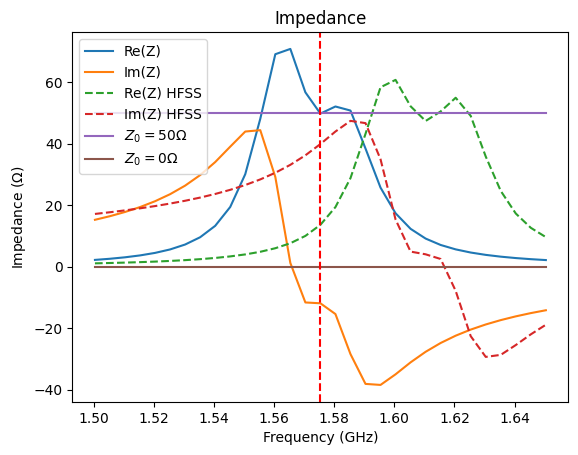

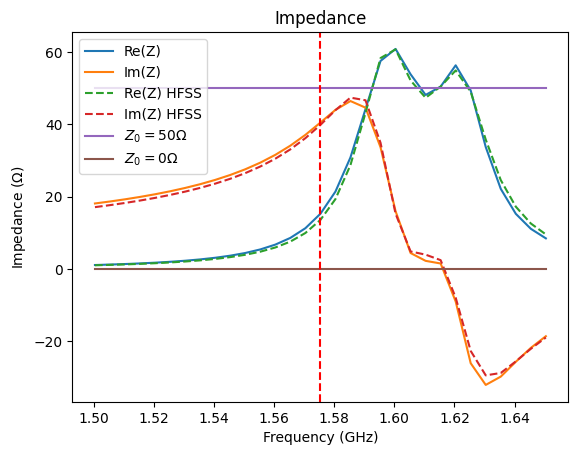

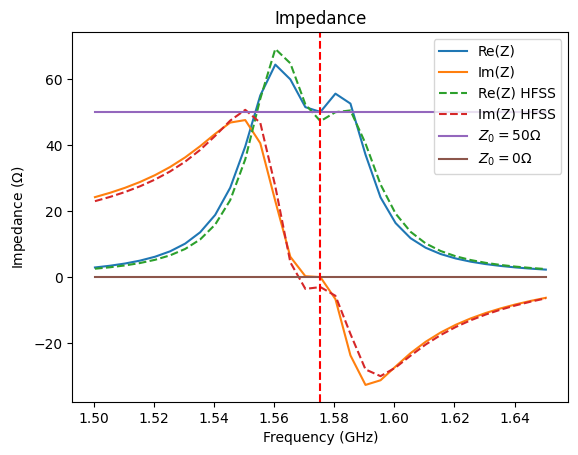

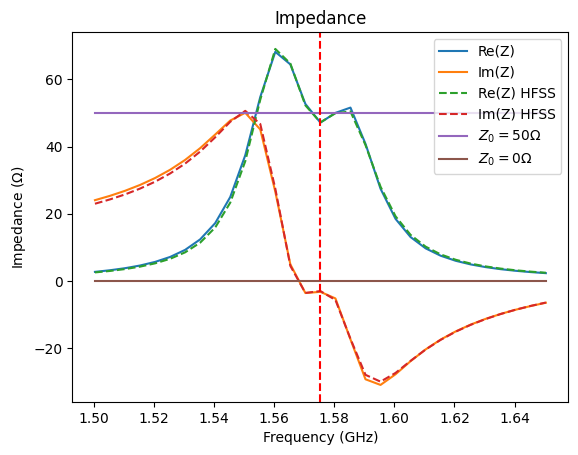

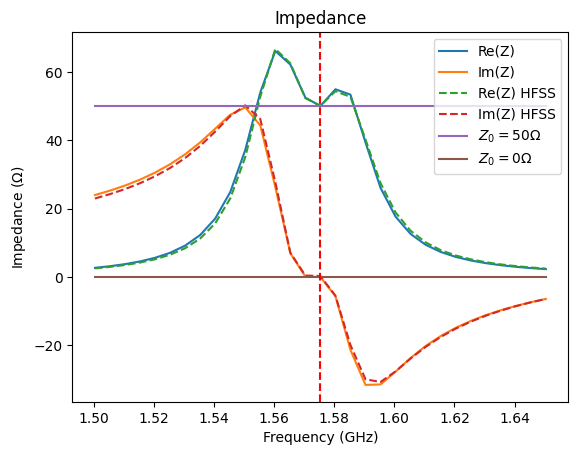

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from Analise_CP import Z_par_g
from Sintese_CP import synth_ant, synth_ant_pos
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime
from scipy.odr import ODR, Model, RealData

sweep = [freq_range[0], freq_range[1], npoints]
freqs = np.linspace(freq_range[0], freq_range[1], npoints)
rtd = 180/np.pi
Z0 = 50
iT = 0

with open("history.txt", "a", encoding="utf-8") as f:
    f.write(f"{datetime.now().strftime('%d/%m/%Y %H:%M:%S')}\n")
    f.write("Param: Dthetaa, Dphia, thetap1, phip1\n")
    f.write("Estim: Dphip, Y, phip_pos, tg01, tg10, deltatheta, deltaPhi\n\n")

    # I)
    param, estim = synth_ant(center_freq)
    print('param: ',param*rtd)
    print('estim: ',estim)
    f.write(f"Iteration {iT}:\n")
    f.write(f"-> Parameters (rad): {param}\n")
    f.write(f"-> Estimates: {estim}\n")
    f.write(f"-> Parameters (deg): {param*rtd}\n\n")

    hfss["Dthetaa"] = str(round(param[0]*rtd,4)) + "deg"
    hfss["Dphia"] = str(round(param[1]*rtd,4)) + "deg"
    hfss["thetap1"] = str(round(param[2]*rtd,4)) + "deg"
    hfss["phip1"] = str(round(param[3]*rtd,4)) + "deg"

    # II)
    setup.analyze()
    #try:
    #    hfss.post.delete_report("Z_11_HFSS_1")
    #except:
    #    pass
    reportZ = hfss.post.create_report(expressions=["re(ActiveZ(Wave_Port1:1))","im(ActiveZ(Wave_Port1:1))"], setup_sweep_name="GPS_Interpolate", plot_name="Z_11_HFSS_1", variations = hfss.get_nominal_variation())
    hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="Z_11_HFSS_1")
    df = pd.read_csv('Z_11_HFSS_1.csv')
    real_z = df["re(ActiveZ(Wave_Port1:1)) []"].to_numpy()
    imag_z = df["im(ActiveZ(Wave_Port1:1)) []"].to_numpy()

    estimIt = estim
    #weights = np.exp(-0.5 * (np.linspace(-1, 1, npoints) / 0.8)**2)
    #weights /= weights.sum()

    #freq_range = [1.55042e9, 1.60042e9]
    #int_sweep.props["RangeStart"]=str(freq_range[0]/1e9)+"GHz"
    #int_sweep.props["RangeEnd"]=str(freq_range[1]/1e9)+"GHz"
    #int_sweep.update()
    bounds = [(1e-3, 0.1), (1e-3, 2), (-13e-3, 13e-3), (1e-3, 0.1), (1e-3, 0.1), (1e-3, estim[5]+1e-3), (1e-3, estim[6]+1e-3)]
    
    while 1:
        iT +=1
        if iT>5:
            break
        # III)
        def Z_theory(estimIt):
            Dphip, Y, phip_pos, tg01, tg10, deltatheta, deltaPhi = estimIt
            return Z_par_g(Dphip, Y, phip_pos, tg01, tg10, deltatheta, deltaPhi, param[0], param[1], param[2], param[3], sweep)

        # IV)
        ZinP = Z_theory(estimIt)
        
        plt.figure()
        plt.plot(freqs / 1e9, np.real(ZinP), label='Re(Z)')
        plt.plot(freqs / 1e9, np.imag(ZinP), label='Im(Z)')
        plt.plot(freqs / 1e9, real_z, label='Re(Z) HFSS', linestyle='--')
        plt.plot(freqs / 1e9, imag_z, label='Im(Z) HFSS', linestyle='--')
        plt.plot(freqs / 1e9, [Z0] * len(freqs), label=r'$Z_0=50\Omega$')
        plt.plot(freqs / 1e9, [0] * len(freqs), label=r'$Z_0=0\Omega$')
        plt.axvline(x=center_freq / 1e9, color='r', linestyle='--')
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Impedance (' + r'$\Omega$' + ')')
        plt.title('Impedance')
        plt.legend()
        #plt.grid(True)
        plt.savefig('impedance_comparison'+str(iT)+'.png', format='png', dpi=300)

        Zhfss = real_z+1j*imag_z
        s11 = 20*np.log10(np.abs((Zhfss-Z0)/(Zhfss+Z0)))

        if s11[int((npoints-1)/2)] < -28:
            print('s11: ', s11, "\n", s11[int((npoints-1)/2)], np.argmin(s11))
            break
        else:
            print('s11: ', s11, "\n", s11[int((npoints-1)/2)], np.argmin(s11))

        def cost(estimCost):
            estimCost = np.round(estimCost, 5)
            for i, (low, high) in enumerate(bounds):
                if not (low <= estimCost[i] <= high):
                    #print('Fora1')
                    return 1e6
            #if np.abs(estimCost[4]-estimCost[3]) > 1e-4:
            #    #print('Fora2')
            #    return 1e6
            #if iT == 1:
            Zt = Z_theory(estimCost)
            cosRes = np.sqrt(np.sum(((np.real(Zt) - real_z)/(real_z+1e-3)) ** 2 + ((np.imag(Zt) - imag_z)/(imag_z+1e-3)) ** 2)) / npoints
            #else:
            #    cosRes = np.sqrt(np.sum(weights*(((np.real(Zt) - real_z)) ** 2 + ((np.imag(Zt) - imag_z)) ** 2)))
            # print("-> Costs: ", cosRes, estimCost)
            return np.round(cosRes,6)

        if iT == 1:
            estimIt[3] *= 1.2
            estimIt[4] *= 1.2
            estimIt[0] *= 1.1
            estimIt[1] = 0.8
            estimIt[2] = -8e-3
            estimIt[5] *= 3/5
            estimIt[6] *= 3/5
            f.write(f"\n-> Estimates between: {estimIt}\n")

        #print('->bef<-')
        #print(estimIt)
        #result = minimize(cost, estimIt, method='nelder-mead', tol=1e-5)
        #print('->aft<-')

        #estimIt = result.x
        #estimIt[2] =0
        #ZinP = Z_theory(estimIt)

        for _ in range(2):
            print('->bef<-')
            print(estimIt)
            result = minimize(cost, estimIt, method='nelder-mead', tol=1e-10)
            print('->aft<-')

            estimIt = result.x
        print('estimIt_pos_1: ', estimIt)

        ####################################################

        def Z_theory_odr(beta, x):
            for val, (low, high) in zip(beta, bounds):
                if not (low <= val <= high):
                    return 1e10
            f, i = x
            v = Z_par_g(*beta, param[0], param[1], param[2], param[3], [f, f, 1])
            return np.real(v) * i + np.imag(v) * (1 - i)

        x_full = np.concatenate([freqs, freqs])
        i_full = np.concatenate([np.ones_like(freqs), np.zeros_like(freqs)])
        X = np.vstack([x_full, i_full])
        y_full = np.concatenate([real_z, imag_z])
        sx = np.full_like(X, 0.01)
        sy = np.full_like(y_full, 0.01)

        odr = ODR(RealData(X, y_full, sx=sx, sy=sy), Model(Z_theory_odr), beta0=estimIt)
        estimIt = odr.run().beta

        print("Adjusted ODR Parameters:", estimIt)

        ZinP = [Z_par_g(*estimIt, param[0], param[1], param[2], param[3], [f, f, 1])[0] for f in freqs]
                                            
        plt.figure()
        plt.plot(freqs / 1e9, np.real(ZinP), label='Re(Z)')
        plt.plot(freqs / 1e9, np.imag(ZinP), label='Im(Z)')
        plt.plot(freqs / 1e9, real_z, label='Re(Z) HFSS', linestyle='--')
        plt.plot(freqs / 1e9, imag_z, label='Im(Z) HFSS', linestyle='--')
        plt.plot(freqs / 1e9, [Z0] * len(freqs), label=r'$Z_0=50\Omega$')
        plt.plot(freqs / 1e9, [0] * len(freqs), label=r'$Z_0=0\Omega$')
        plt.axvline(x=center_freq / 1e9, color='r', linestyle='--')
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Impedance (' + r'$\Omega$' + ')')
        plt.title('Impedance')
        plt.legend()
        #plt.grid(True)
        plt.savefig('impedance_post_comparison'+str(iT)+'.png', format='png', dpi=300)

        # V)
        param = synth_ant_pos(center_freq, estimIt)
        print('pos: ', param*rtd)
        print('estim_pos: ', estimIt)
        f.write(f"Iteration {iT}:\n")
        f.write(f"-> Parameters (rad): {param}\n")
        f.write(f"-> Estimates: {estimIt}\n")
        f.write(f"-> Parameters (deg): {param*rtd}\n\n")
        if np.isnan(param).any():
            break
        
        hfss["Dthetaa"] = str(round(param[0]*rtd,4)) + "deg"
        hfss["Dphia"] = str(round(param[1]*rtd,4)) + "deg"
        hfss["thetap1"] = str(round(param[2]*rtd,4)) + "deg"
        hfss["phip1"] = str(round(param[3]*rtd,4)) + "deg"
        
        #sweep = [freq_range[0], freq_range[1], npoints]
        
        #freqs = np.linspace(freq_range[0], freq_range[1], npoints)

        setup.analyze()
        
        hfss.post.update_report_dynamically = True
        reportZ_int = hfss.post.create_report(expressions=["re(ActiveZ(Wave_Port1:1))","im(ActiveZ(Wave_Port1:1))"], setup_sweep_name="GPS_Interpolate", plot_name="Z_11_HFSS_"+str(iT+1))
        hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="Z_11_HFSS_"+str(iT+1))
        df = pd.read_csv('Z_11_HFSS_'+str(iT+1)+'.csv')
        real_z = df["re(ActiveZ(Wave_Port1:1)) []"].to_numpy()
        imag_z = df["im(ActiveZ(Wave_Port1:1)) []"].to_numpy()

In [6]:
mesh_plot = hfss.post.create_fieldplot_volume(["Diel_Sphere"], quantity="Mesh", field_type="Fields", setup="GPS_Band : LastAdaptive", plot_name="Diel_Mesh")

freq_range = [1.50042e9, 1.65042e9]      # Frequency range for analysis and post-processing.

disc_sweep = setup.add_sweep(name="GPS_Discrete", sweep_type="Discrete", RangeStart=str(freq_range[0]/1e9)+"GHz", RangeEnd=str(freq_range[1]/1e9)+"GHz", RangeCount = npoints, SaveFields=True)
setup.props['MinimumConvergedPasses'] = 5
disc_sweep.props['RangeCount'] = 31
disc_sweep.update()
sweep = [freq_range[0], freq_range[1], 31]
freqs = np.linspace(freq_range[0], freq_range[1], 31)

setup.update()
setup.analyze()

reportZ = hfss.post.create_report(expressions=["re(ActiveZ(Wave_Port1:1))","im(ActiveZ(Wave_Port1:1))"], variations=hfss.get_nominal_variation(), setup_sweep_name="GPS_Discrete", plot_name="Z_11_HFSS_Final")
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="Z_11_HFSS_Final")
df = pd.read_csv('Z_11_HFSS_Final.csv')
real_z = df["re(ActiveZ(Wave_Port1:1)) []"].to_numpy()
imag_z = df["im(ActiveZ(Wave_Port1:1)) []"].to_numpy()

PyAEDT INFO: Parsing design objects. This operation can take time
PyAEDT INFO: Refreshing bodies from Object Info
PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec
PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec
PyAEDT INFO: Active Design set to CP
PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.
PyAEDT INFO: Solving design setup GPS_Band
PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.
PyAEDT INFO: Design setup GPS_Band solved correctly in 0.0h 32.0m 42.0s


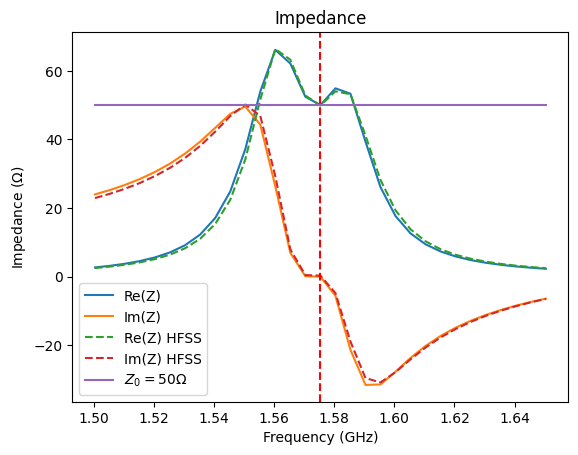

In [7]:
Dphip, Y, phip_pos, tg01, tg10, deltatheta, deltaPhi = estimIt
ZinP = Z_par_g(Dphip, Y, phip_pos, tg01, tg10, deltatheta, deltaPhi, param[0], param[1], param[2], param[3], sweep)

plt.figure()
plt.plot(freqs / 1e9, np.real(ZinP), label='Re(Z)')
plt.plot(freqs / 1e9, np.imag(ZinP), label='Im(Z)')
plt.plot(freqs / 1e9, real_z, label='Re(Z) HFSS', linestyle='--')
plt.plot(freqs / 1e9, imag_z, label='Im(Z) HFSS', linestyle='--')
plt.plot(freqs / 1e9, [Z0] * len(freqs), label=r'$Z_0=50\Omega$')
plt.axvline(x=center_freq / 1e9, color='r', linestyle='--')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Impedance (' + r'$\Omega$' + ')')
plt.title('Impedance')
plt.legend()
#plt.grid(True)
plt.savefig('impedance_comparison_final.png', format='png', dpi=300)

In [8]:
Rad_3D = hfss.field_setups[0]
print(Rad_3D.name)
Rad_3D.theta_step = "1deg"
Rad_3D.phi_step = "1deg"
Rad_3D.theta_start = "-180deg"

variations = hfss.available_variations.nominal_values
variations["Freq"] = ["All"]
variations["Theta"] = ["90deg"]
variations["Phi"] = ["90deg"]
axialratio_ffd_plot = hfss.post.create_report(expressions="dB(AxialRatioValue)",
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             primary_sweep_variable="Freq",
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="Rectangular Plot",
                                             plot_name="Axial Ratio (dB)"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="Axial Ratio (dB)")

3D


'C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes\\Axial Ratio (dB).csv'

In [9]:
hfss.post.update_report_dynamically = True

variations = hfss.available_variations.nominal_values
variations["Freq"] = ["1.57542GHz"]
variations["Theta"] = ["90deg"]
variations["Phi"] = ["All"]
axialratio_ffd_plot = hfss.post.create_report(expressions="dB(AxialRatioValue)",
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             primary_sweep_variable="Phi",
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="Rectangular Plot",
                                             plot_name="Axial Ratio Theta90 (dB)"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="Axial Ratio Theta90 (dB)")

variations = hfss.available_variations.nominal_values
variations["Freq"] = ["1.57542GHz"]
variations["Theta"] = ["All"]
variations["Phi"] = ["90deg"]
axialratio_ffd_plot = hfss.post.create_report(expressions="dB(AxialRatioValue)",
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             primary_sweep_variable="Theta",
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="Rectangular Plot",
                                             plot_name="Axial Ratio Phi90 (dB)"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="Axial Ratio Phi90 (dB)")

variations = hfss.available_variations.nominal_values
variations["Freq"] = ["1.57542GHz"]
variations["Theta"] = ["All"]
variations["Phi"] = ["All"]
gain_ffd_plot = hfss.post.create_report(expressions=["dB(GainLHCP)", "dB(GainRHCP)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="3D Polar Plot",
                                             plot_name="Gain 3D (dB)"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="Gain 3D (dB)")

variations = hfss.available_variations.nominal_values
variations["Freq"] = ["1.57542GHz"]
variations["Theta"] = ["90deg"]
variations["Phi"] = ["All"]
gain_ffd_plot = hfss.post.create_report(expressions=["dB(GainLHCP)", "dB(GainRHCP)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             primary_sweep_variable="Phi",
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="Radiation Pattern",
                                             plot_name="Gain Theta90 (dB)"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="Gain Theta90 (dB)")

variations = hfss.available_variations.nominal_values
variations["Freq"] = ["1.57542GHz"]
variations["Theta"] = ["All"]
variations["Phi"] = ["90deg"]
gain_ffd_plot = hfss.post.create_report(expressions=["dB(GainLHCP)", "dB(GainRHCP)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             primary_sweep_variable="Theta",
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="Radiation Pattern",
                                             plot_name="Gain Phi90 (dB)"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="Gain Phi90 (dB)")

reportS = hfss.post.create_report(expressions=["dB(S(Wave_Port1,Wave_Port1))"], setup_sweep_name="GPS_Discrete", plot_name="S_11", variations = hfss.get_nominal_variation())
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="S_11")

hfss.post.export_model_picture(full_name="C:\\Users\\ITA\\Documents\\Alunos\\JoaoPedroFalcao\\Mestrado\\Codes\\Back_View.png", show_axis=True, show_grid=True, show_ruler=True, show_region='Default', selections=["Diel_Sphere", "Patch1"], field_selections="all", orientation='back', width=0, height=0)


'C:\\Users\\ITA\\Documents\\Alunos\\JoaoPedroFalcao\\Mestrado\\Codes\\Back_View.png'

In [10]:
variations = hfss.available_variations.nominal_values
variations["Freq"] = ["1.57542GHz"]
variations["Theta"] = ["All"]
variations["Phi"] = ["All"]
gain_ffd_plot = hfss.post.create_report(expressions=["re(rEPhi)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="3D Polar Plot",
                                             plot_name="rE_Phi_re"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="rE_Phi_re")

gain_ffd_plot = hfss.post.create_report(expressions=["im(rEPhi)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="3D Polar Plot",
                                             plot_name="rE_Phi_im"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="rE_Phi_im")

gain_ffd_plot = hfss.post.create_report(expressions=["re(rETheta)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="3D Polar Plot",
                                             plot_name="rE_Theta_re"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="rE_Theta_re")

gain_ffd_plot = hfss.post.create_report(expressions=["im(rETheta)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="3D Polar Plot",
                                             plot_name="rE_Theta_im"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="rE_Theta_im")

'C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes\\rE_Theta_im.csv'

# Workbench

In [ ]:
#reportEff = hfss.post.create_report(expressions="RadiationEfficiency", quantities_category=, context="3D", setup_sweep_name="GPS_Band : LastAdaptive", plot_name="Efficiency", plot_type="Rectangular Plot", report_category="Antenna Parameters", variations = hfss.get_nominal_variation(), primary_sweep_variable="Freq")
#hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="Efficiency")

print(hfss.post.get_solution_data_per_variation())

In [11]:
hfss.save_project()
hfss.release_desktop()

# Wait 2 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(2)

temp_folder.cleanup()

PyAEDT INFO: Project Spherical_Array Saved correctly
PyAEDT INFO: Desktop has been released and closed.
